**Table of contents**<a id='toc0_'></a>    
- [Codewars Solutions Analysis](#toc1_)    
  - [About Codewars](#toc1_1_)    
  - [Imports](#toc1_2_)    
    - [Load Pre-existing Data](#toc1_2_1_)    
  - [Data Collection](#toc1_3_)    
    - [Run the Scraper](#toc1_3_1_)    
    - [Retrieve any New Problems](#toc1_3_2_)    
  - [Looping through data files](#toc1_4_)    
  - [Generating dictionary for dataframe](#toc1_5_)    
  - [API Requests](#toc1_6_)    
    - [Test API Request](#toc1_6_1_)    
      - [Test With "Hello World" kata](#toc1_6_1_1_)    
      - [Retrieve All Problems Information](#toc1_6_1_2_)    
    - [Store Data in Dataframe](#toc1_6_2_)    
    - [Append New Data to Stored Dataframe](#toc1_6_3_)    
    - [Save Dataframe as CSV](#toc1_6_4_)    
    - [Inspect Dataframe](#toc1_6_5_)    
  - [Analysis](#toc1_7_)    
    - [Analysis of Languages](#toc1_7_1_)    
      - [First Appearance For Each Language](#toc1_7_1_1_)    
      - [Representation of Languages Over Time](#toc1_7_1_2_)    
    - [Analysis of Tags](#toc1_7_2_)    
      - [Tag Frequency](#toc1_7_2_1_)    
      - [Lollipop chart](#toc1_7_2_2_)    
      - [Top Tag Representation Over Time](#toc1_7_2_3_)    
      - [Tags vs Language Heatmap](#toc1_7_2_4_)    
  - [Difficulty Analysis](#toc1_8_)    
    - [Convert Difficulties into Numerical Values](#toc1_8_1_)    
      - [Kata Completion Ratios](#toc1_8_1_1_)    
      - [Most Difficult Kata Solved](#toc1_8_1_2_)    
- [Text align justify](#toc2_)    
      - [Rarest Kata](#toc2_1_1_1_)    
- [Maximum 2d subarray sum](#toc3_)    
      - [Most Problematic Kata](#toc3_1_1_1_)    
- [Codewars style ranking system](#toc4_)    
      - [Favourite Authors](#toc4_1_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Codewars Solutions Analysis](#toc0_)

## <a id='toc1_1_'></a>[About Codewars](#toc0_)

Codewars is a community driven website where users can submit and solve "Kata".

Kata are simply coding problems to be solved.

Codewars features an extensive list of languages allowed, ranging from well established languages to more obscure ones such as Prolog.

Throughout this notebook I scrape all the solutions to the kata I have completed alongside additional information, then analyse the data through a series of visualisations

## <a id='toc1_2_'></a>[Imports](#toc0_)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import requests
import json
from time import sleep
%matplotlib inline

In [2]:
# Set style to Solarize_Light2, the best style
plt.style.use('Solarize_Light2')

### <a id='toc1_2_1_'></a>[Load Pre-existing Data](#toc0_)

In [3]:
# Load the dataframe from .csv so we can ensure we don't create duplicate entries
# Also so we don't have to scrape the site fully every time we run the notebook
if os.path.isfile('codewars.csv'):
    codewars_df = pd.read_csv('codewars.csv')

## <a id='toc1_3_'></a>[Data Collection](#toc0_)

Whilst Codewars does have an API, only the user themselves are able to view their completed Kata
Thus we use a webscraper to download the full solution set
We can query the API for full details about each problem

In [4]:
# Initialise git submodule if it doesn't exist
if not os.path.isdir('codewars_scraper'):
    !git submodule add https://github.com/Eatkin/codewars-scraper.git codewars_scraper

!git submodule update --remote codewars_scraper

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 3 (delta 2), reused 3 (delta 2), pack-reused 0
Unpacking objects: 100% (3/3), 352 bytes | 176.00 KiB/s, done.
From https://github.com/Eatkin/codewars-scraper
   86aeae2..60a2fa3  main       -> origin/main
Submodule path 'codewars_scraper': checked out '60a2fa3362094179ac47b0652c09a12e49a445e1'


In [5]:
# Initialising the git submodule can change our directory so make sure we're back in the correct place
# Also add an init file so we can import the scraper as a module
if os.getcwd().endswith('codewars_scraper'):
    !touch __init__.py
    os.chdir(os.path.dirname(os.getcwd()))
else:
    os.chdir('codewars_scraper')
    !touch __init__.py
    os.chdir(os.path.dirname(os.getcwd()))

os.getcwd()

'/home/ed/code/Eatkin/codewars/codewars-analysis'

### <a id='toc1_3_1_'></a>[Run the Scraper](#toc0_)
You can run the scraper outside this Notebook by running python scraper.py and following the instructions

### <a id='toc1_3_2_'></a>[Retrieve any New Problems](#toc0_)

In [6]:
# Retrieve language filetypes
from codewars_scraper.scraper import language_filetypes
language_filetypes

{'c': '.c',
 'javascript': '.js',
 'python': '.py',
 'shell': '.sh',
 'c#': '.cs',
 'sql': '.sql',
 'bf': '.bf',
 'prolog': '.pl',
 'powershell': '.ps1',
 'coffeescript': '.coffee'}

In [11]:
# Import new problems to the data folder
# This is a "dumb" copy, it doesn't check if the problem already exists
import shutil

source_directory = 'codewars_scraper/'
destination_directory = 'data/'

# Iterate over the keys of the language_filetypes dictionary
for language in language_filetypes:
    # Find the matching folder name (case-insensitive)
    matching_folder = next((folder for folder in os.listdir(source_directory) if folder.lower() == language.lower()), None)
    
    # Construct the source and destination paths for the current language
    if matching_folder:
        source_path = os.path.join(source_directory, matching_folder)
        destination_path = os.path.join(destination_directory, matching_folder)

        # This removes the destination directory if it already exists
        if os.path.exists(destination_path):
            shutil.rmtree(destination_path)
    

        # Copy the source directory to the destination directory
        shutil.copytree(source_path, destination_path)

## <a id='toc1_4_'></a>[Looping through data files](#toc0_)

In [12]:
# This will loop through every file in the data folder and extract the link
path = "data/"

count = 0

for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            link = f.readline().strip()
            count += 1
            
print(f"Found {count} files")

Found 600 files


## <a id='toc1_5_'></a>[Generating dictionary for dataframe](#toc0_)

In [13]:
# regex to extract the kata ID
pattern = re.compile(r'^.*kata/(.*)$')
# regex to extract version number
revision_pattern = re.compile(r'.*-v(\d+)-.*')

In [14]:
# Loop through all files to collect kata ID, language and revision numbers
data_list = []

base_url = "https://www.codewars.com/kata/"

# Check if dataframe exists
dataframe_exists = False
if os.path.isfile('codewars.csv'):
    dataframe_exists = True

# loop through files
for root, dirs, files in os.walk(path):
    for name in files:
        with open(os.path.join(root, name), 'r') as f:
            lines = f.readlines()

            # extract problem id from first line of file
            first_line = lines[0].strip()
            problem_id = re.search(pattern, first_line).group(1)
            
            # extract date from second line of file
            date = lines[1].strip()
            # remove comment if it exists
            date = re.search(r"^.*?(\d{4}.*)$", date).group(1)
            date = re.sub(r'T', ' ', date)
            date = re.sub(r'\+\d{4}', '', date)
            
            # Before we continue, check if we already have an entry for this kata
            # The date will be unique, since it's down to the nearest millisecond
            # so we can use that to check
            if dataframe_exists and codewars_df[codewars_df['date_time'] == date].shape[0] > 0:
                continue
            
            # construct link
            link = base_url + problem_id

            # extract language from folder name
            language = os.path.basename(root)

            # extract revision from file name
            match = re.search(revision_pattern, name)
            if match:
                revision = match.group(1)
            else:
                revision = 1

            # extract solution from file contents
            solution = '\n'.join(lines[2:])

            # create dictionary and add to list
            data_dict = {
                'problem_id': problem_id,
                'language': language,
                'revision': int(revision),
                'solution': solution,
                'link': link,
                'date_time': date
            }
            data_list.append(data_dict)

if data_list != []:
    print("Added", len(data_list), "new problems")
else:
    print("No new problems found")

Added 233 new problems


## <a id='toc1_6_'></a>[API Requests](#toc0_)

The API requests take the form:
https://www.codewars.com/api/v1/code-challenges/{challenge_id}

The response is of the format:
Field	| Type | Description
| --- | --- | --- |
id | string | ID of the kata.
name | string | Name of the kata.
slug | string | Slug of the kata.
url | string | URL of the kata.
category | string | Category of the kata.
description | string | Description of the kata in Markdown.
tags | string[] | Array of tags associated with the kata.
languages | string[] | Array of language names the kata is available in.
rank | object? | Object describing the rank of the kata if approved.
createdBy | object | The author of the kata.
publishedAt | string | Date and time when the kata was first published.
approvedBy | object? | The approver of the kata.
approvedAt | string | Date and time when the kata was approved.
totalCompleted | number | Total number of completions.
totalAttempts | number | Total number of attempts.
totalStars | number | The number of bookmarks.
voteScore | number | The sum of all votes casted.
contributorsWanted | boolean | Whether to allow contributions.
unresolved | object | Object with fields issues and suggestions for the number of unresolved issues and suggestions respectively.

### <a id='toc1_6_1_'></a>[Test API Request](#toc0_)

#### <a id='toc1_6_1_1_'></a>[Test With "Hello World" kata](#toc0_)

In [15]:
# We want to retrieve name, rank, totalAttempts, totalCompleted, createdBy, publishedAt, category, totalStars, voteScore, unresolved, tags
URL = 'https://www.codewars.com/api/v1/code-challenges/'
problem_id = '523b4ff7adca849afe000035'
response = requests.get(URL + problem_id)
if response.status_code == 200:
    print(json.dumps(response.json(), indent=4))

{
    "id": "523b4ff7adca849afe000035",
    "name": "Function 1 - hello world",
    "slug": "function-1-hello-world",
    "category": "reference",
    "publishedAt": "2013-09-19T20:36:41.798Z",
    "approvedAt": null,
    "languages": [
        "javascript",
        "ruby",
        "python",
        "java",
        "haskell",
        "csharp",
        "elixir",
        "r",
        "php",
        "objc",
        "lua",
        "julia",
        "groovy",
        "go",
        "crystal",
        "dart",
        "powershell",
        "clojure",
        "nasm",
        "coffeescript",
        "c",
        "shell",
        "erlang",
        "rust",
        "prolog",
        "swift",
        "cfml",
        "racket",
        "reason",
        "typescript",
        "elm",
        "purescript",
        "factor",
        "cpp",
        "kotlin",
        "commonlisp",
        "cobol",
        "scala",
        "ocaml",
        "pascal"
    ],
    "url": "https://www.codewars.com/kata/523b4ff7adca

In [16]:
# Retrieve just the information we want:
print("Name:", response.json()['name'])
print("Rank:", response.json()['rank']['name'])
print("Rank category", response.json()['rank']['color'])
print("Total attempts:", response.json()['totalAttempts'])
print("Total completed:", response.json()['totalCompleted'])
print("Created by:", response.json()['createdBy']['username'])
print("Published at:", response.json()['publishedAt'])
print("Category:", response.json()['category'])
print("Total stars:", response.json()['totalStars'])
print("Vote score:", response.json()['voteScore'])
print("Issues:", response.json()['unresolved']['issues'])
print("Suggestions:", response.json()['unresolved']['suggestions'])
print("Tags:", response.json()['tags'])

Name: Function 1 - hello world
Rank: 8 kyu
Rank category white
Total attempts: 432274
Total completed: 191300
Created by: ineiti
Published at: 2013-09-19T20:36:41.798Z
Category: reference
Total stars: 802
Vote score: 7780
Issues: 4
Suggestions: 0
Tags: ['Fundamentals']


#### <a id='toc1_6_1_2_'></a>[Retrieve All Problems Information](#toc0_)

In [17]:
# Define functions
def get_problem_info(id):
    URL = URL = 'https://www.codewars.com/api/v1/code-challenges/'
    response = requests.get(URL + id)
    if response.status_code == 200:
        return response.json()
    else:
        print("Error retrieving problem info")
        return None
    
def parse_problem(problem_json):
    info_dict = {}
    info_dict['title'] = problem_json['name']
    info_dict['difficulty'] = problem_json['rank']['name']
    info_dict['difficulty_category'] = problem_json['rank']['color']
    info_dict['attempts'] = problem_json['totalAttempts']
    info_dict['completion_count'] = problem_json['totalCompleted']
    # Not all kata have an author
    try:
        info_dict['author'] = problem_json['createdBy']['username']
    except:
        info_dict['author'] = np.nan
    info_dict['tags'] = problem_json['tags']
    info_dict['published_at'] = problem_json['publishedAt']
    info_dict['category'] = problem_json['category']
    info_dict['total_stars'] = problem_json['totalStars']
    info_dict['vote_score'] = problem_json['voteScore']
    info_dict['issues'] = problem_json['unresolved']['issues']
    info_dict['suggestions'] = problem_json['unresolved']['suggestions']
    return info_dict
    

In [18]:
# Loop through all problems and parse the info
problem_num = 0
for problem in data_list:
    problem_num += 1
    # Skip any that have already been parsed
    if 'difficulty' in problem:
        continue
    
    p_id = problem['problem_id']
    
    print("Parsing problem", problem_num, "of", len(data_list))
    print("ID:", p_id)
    
    info = get_problem_info(p_id)
    if info:
        parsed_info = parse_problem(info)
        data_list[problem_num - 1].update(parsed_info)
        
    sleep(5)

Parsing problem 1 of 233
ID: 50654ddff44f800200000004
Parsing problem 2 of 233
ID: 52fba66badcd10859f00097e
Parsing problem 3 of 233
ID: 5667e8f4e3f572a8f2000039
Parsing problem 4 of 233
ID: 526571aae218b8ee490006f4
Parsing problem 5 of 233
ID: 5ae62fcf252e66d44d00008e
Parsing problem 6 of 233
ID: 53da3dbb4a5168369a0000fe
Parsing problem 7 of 233
ID: 55225023e1be1ec8bc000390
Parsing problem 8 of 233
ID: 5a3fe3dde1ce0e8ed6000097
Parsing problem 9 of 233
ID: 55edaba99da3a9c84000003b
Parsing problem 10 of 233
ID: 55f9bca8ecaa9eac7100004a
Parsing problem 11 of 233
ID: 5300901726d12b80e8000498
Parsing problem 12 of 233
ID: 55f9b48403f6b87a7c0000bd
Parsing problem 13 of 233
ID: 5738f5ea9545204cec000155
Parsing problem 14 of 233
ID: 55f2b110f61eb01779000053
Parsing problem 15 of 233
ID: 5ce9c1000bab0b001134f5af
Parsing problem 16 of 233
ID: 55fab1ffda3e2e44f00000c6
Parsing problem 17 of 233
ID: 563e320cee5dddcf77000158
Parsing problem 18 of 233
ID: 5ae62fcf252e66d44d00008e
Parsing problem 19 

In [21]:
if data_list != []:
    print(data_list[0])

{'problem_id': '50654ddff44f800200000004', 'language': 'Shell', 'revision': 1, 'solution': '#!/bin/bash -e\n\na=$1\n\nb=$2\n\necho $(($1*$2))', 'link': 'https://www.codewars.com/kata/50654ddff44f800200000004', 'date_time': '2023-06-02 08:29:49.221', 'title': 'Multiply', 'difficulty': '8 kyu', 'difficulty_category': 'white', 'attempts': 6658509, 'completion_count': 5478968, 'author': nan, 'tags': ['Debugging', 'Fundamentals'], 'published_at': '2013-05-18T18:40:17.975Z', 'category': 'bug_fixes', 'total_stars': 2198, 'vote_score': 18076, 'issues': 1, 'suggestions': 0}


In [22]:
if data_list != []:
    print(data_list[-1])

{'problem_id': '51b62bf6a9c58071c600001b', 'language': 'JavaScript', 'revision': 1, 'solution': 'const numerals = {\n\n  1: "I",\n\n  4: "IV",\n\n  5: "V",\n\n  9: "IX",\n\n  10: "X",\n\n  40: "XL",\n\n  50: "L",\n\n  90: "XC",\n\n  100: "C",\n\n  400: "CD",\n\n  500: "D",\n\n  900: "CM",\n\n  1000: "M"\n\n}\n\n\n\nfunction solution(number){\n\n  let keys = Object.keys(numerals).reverse();\n\n  let numeral_representation = "";\n\n  for (let i = 0; i < keys.length; i++) {\n\n    let value = keys[i]\n\n    let count = Math.floor(number / value);\n\n    numeral_representation += numerals[value].repeat(count);\n\n    number -= value * count;\n\n  }\n\n  \n\n  return numeral_representation;\n\n}', 'link': 'https://www.codewars.com/kata/51b62bf6a9c58071c600001b', 'date_time': '2023-06-01 14:39:20.144', 'title': 'Roman Numerals Encoder', 'difficulty': '6 kyu', 'difficulty_category': 'yellow', 'attempts': 187065, 'completion_count': 45903, 'author': 'jhoffner', 'tags': ['Algorithms'], 'publish

### <a id='toc1_6_2_'></a>[Store Data in Dataframe](#toc0_)
Note the dataframe name. This is because codewars_df may already exist
We with to only append new data

In [23]:
# Now we have some new data, let's make a dataframe
new_codewars_df = pd.DataFrame(data_list)
new_codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,50654ddff44f800200000004,Shell,1,#!/bin/bash -e\n\na=$1\n\nb=$2\n\necho $(($1*$2)),https://www.codewars.com/kata/50654ddff44f8002...,2023-06-02 08:29:49.221,Multiply,8 kyu,white,6658509,5478968,NaN,"[Debugging, Fundamentals]",2013-05-18T18:40:17.975Z,bug_fixes,2198,18076,1,0
1,52fba66badcd10859f00097e,Shell,1,#!/bin/bash\n\n\n\n# your code here #input tex...,https://www.codewars.com/kata/52fba66badcd1085...,2023-06-02 08:18:59.244,Disemvowel Trolls,7 kyu,white,812969,282103,osuushi,"[Strings, Regular Expressions, Fundamentals]",2014-02-12T16:54:28.937Z,reference,2650,19232,3,2
2,5667e8f4e3f572a8f2000039,Shell,1,"#!/bin/bash\n\naccum () {\n\n str=""""\n\n ...",https://www.codewars.com/kata/5667e8f4e3f572a8...,2023-06-02 08:53:59.411,Mumbling,7 kyu,white,589270,190206,g964,"[Fundamentals, Strings, Puzzles]",2015-12-09T08:40:29.276Z,reference,2944,15484,0,1
3,526571aae218b8ee490006f4,Shell,1,"#!/bin/bash\n\nn=$1\n\necho ""$(echo ""ibase=10;...",https://www.codewars.com/kata/526571aae218b8ee...,2023-06-02 08:36:06.915,Bit Counting,6 kyu,yellow,485487,199990,xcthulhu,"[Bits, Algorithms]",2013-10-21T18:27:26.672Z,algorithms,2103,16431,4,1
4,5ae62fcf252e66d44d00008e,Shell,1,a=$1\n\nb=$2\n\nc=$3\n\n# your code here\n\nsu...,https://www.codewars.com/kata/5ae62fcf252e66d4...,2023-05-30 19:22:41.745,Expressions Matter,8 kyu,white,121257,43771,MrZizoScream,"[Algorithms, Fundamentals]",2018-04-29T21:49:35.298Z,reference,776,3273,1,0


In [24]:
new_codewars_df.shape

(233, 19)

In [131]:
new_codewars_df.tail()

NameError: name 'new_codewars_df' is not defined

In [26]:
new_codewars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   problem_id           233 non-null    object
 1   language             233 non-null    object
 2   revision             233 non-null    int64 
 3   solution             233 non-null    object
 4   link                 233 non-null    object
 5   date_time            233 non-null    object
 6   title                233 non-null    object
 7   difficulty           231 non-null    object
 8   difficulty_category  231 non-null    object
 9   attempts             233 non-null    int64 
 10  completion_count     233 non-null    int64 
 11  author               231 non-null    object
 12  tags                 233 non-null    object
 13  published_at         233 non-null    object
 14  category             233 non-null    object
 15  total_stars          233 non-null    int64 
 16  vote_sco

### <a id='toc1_6_3_'></a>[Append New Data to Stored Dataframe](#toc0_)
If the dataframe existed before we started, we may have scraped new data to append

In [27]:
# Append new data to the end of the old dataframe
# We need to check the df exists first incase this is the first scrape
if 'codewars_df' in locals():
    codewars_df = codewars_df.append(new_codewars_df, ignore_index=True)
else:
    codewars_df = new_codewars_df

# Free up some memory since it's now stored twice
del new_codewars_df

/tmp/ipykernel_8984/1390956106.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  codewars_df = codewars_df.append(new_codewars_df, ignore_index=True)


In [28]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,Drying Potatoes,7 kyu,white,62954,9461,g964,"['Fundamentals', 'Puzzles']",2017-03-19T13:30:31.186Z,reference,295,522,2,7
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,Remove First and Last Character,8 kyu,white,470694,216076,Steadyx,"['Strings', 'Fundamentals']",2016-02-11T21:14:31.636Z,reference,1191,13257,3,1
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,Return the latest modified file,7 kyu,white,740,327,ddellaquila,['Fundamentals'],2017-09-18T15:38:39.371Z,reference,5,99,1,0
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,Keep Hydrated!,8 kyu,white,297590,155844,paulrichard,"['Algorithms', 'Mathematics', 'Fundamentals']",2016-11-16T19:47:07.378Z,reference,738,8784,0,3
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,Grasshopper - Terminal game move function,8 kyu,white,62662,45039,danleavitt0,['Fundamentals'],2015-11-07T17:40:01.344Z,reference,152,3129,0,4


In [29]:
codewars_df.shape

(599, 19)

### <a id='toc1_6_4_'></a>[Save Dataframe as CSV](#toc0_)

In [30]:
# Save dataframe to csv
codewars_df.to_csv('codewars.csv', index=False)

In [31]:
# Load the dataframe back in from csv
# We do this because the "tags" column is not a list of strings when we save to csv, but it is when we load from csv
codewars_df = pd.read_csv('codewars.csv')

### <a id='toc1_6_5_'></a>[Inspect Dataframe](#toc0_)

In [32]:
codewars_df.head()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
0,58ce8725c835848ad6000007,Shell,1,#!/bin/bash\n\npi=$1\n\nw=$2\n\npf=$3\n\n\n\ne...,https://www.codewars.com/kata/58ce8725c835848a...,2023-04-08 15:13:48.626,Drying Potatoes,7 kyu,white,62954,9461,g964,"['Fundamentals', 'Puzzles']",2017-03-19T13:30:31.186Z,reference,295,522,2,7
1,56bc28ad5bdaeb48760009b0,Shell,1,function removeChar() {\n\n local str=$1\n\n ...,https://www.codewars.com/kata/56bc28ad5bdaeb48...,2023-03-27 11:00:44.662,Remove First and Last Character,8 kyu,white,470694,216076,Steadyx,"['Strings', 'Fundamentals']",2016-02-11T21:14:31.636Z,reference,1191,13257,3,1
2,59bfe5f15227ddf81900007b,Shell,1,ls -t | head -n 1,https://www.codewars.com/kata/59bfe5f15227ddf8...,2023-04-08 15:20:55.441,Return the latest modified file,7 kyu,white,740,327,ddellaquila,['Fundamentals'],2017-09-18T15:38:39.371Z,reference,5,99,1,0
3,582cb0224e56e068d800003c,Shell,1,def litres(time):\n\n return (time * 0.5)//1,https://www.codewars.com/kata/582cb0224e56e068...,2023-04-17 18:06:43.289,Keep Hydrated!,8 kyu,white,297590,155844,paulrichard,"['Algorithms', 'Mathematics', 'Fundamentals']",2016-11-16T19:47:07.378Z,reference,738,8784,0,3
4,563a631f7cbbc236cf0000c2,Shell,1,position=$1\n\nroll=$2\n\n# your code here\n\n...,https://www.codewars.com/kata/563a631f7cbbc236...,2023-03-31 06:07:28.588,Grasshopper - Terminal game move function,8 kyu,white,62662,45039,danleavitt0,['Fundamentals'],2015-11-07T17:40:01.344Z,reference,152,3129,0,4


In [33]:
codewars_df.tail()

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
594,52a89c2ea8ddc5547a000863,JavaScript,1,function loop_size(node){\n\n let slow = node...,https://www.codewars.com/kata/52a89c2ea8ddc554...,2023-06-01 15:18:01.779,Can you get the loop ?,5 kyu,yellow,218767,24685,Devouring,"['Algorithms', 'Linked Lists', 'Performance']",2013-12-12T11:21:21.557Z,algorithms,1747,2061,15,11
595,56f69d9f9400f508fb000ba7,JavaScript,1,function monkeyCount(n) {\n\n return Array.fr...,https://www.codewars.com/kata/56f69d9f9400f508...,2023-06-02 11:49:33.266,Count the Monkeys!,8 kyu,white,125045,54188,PG1,"['Arrays', 'Fundamentals', 'Lists', 'Algorithms']",2016-03-26T14:33:11.430Z,algorithms,404,5083,2,3
596,55d277882e139d0b6000005d,JavaScript,1,var findAverage = function (nums) {\n\n retur...,https://www.codewars.com/kata/55d277882e139d0b...,2023-06-02 14:59:30.744,Grasshopper - Array Mean,8 kyu,white,34374,17008,danleavitt0,"['Arrays', 'Lists', 'Fundamentals']",2015-08-25T19:22:58.888Z,reference,124,2004,1,0
597,56747fd5cb988479af000028,JavaScript,1,function getMiddle(s)\n\n{\n\n return (s.leng...,https://www.codewars.com/kata/56747fd5cb988479...,2023-06-12 13:07:10.863,Get the Middle Character,7 kyu,white,611653,220241,Shivo,"['Fundamentals', 'Strings']",2015-12-18T22:20:26.345Z,reference,1888,15580,0,5
598,51b62bf6a9c58071c600001b,JavaScript,1,"const numerals = {\n\n 1: ""I"",\n\n 4: ""IV"",\...",https://www.codewars.com/kata/51b62bf6a9c58071...,2023-06-01 14:39:20.144,Roman Numerals Encoder,6 kyu,yellow,187065,45903,jhoffner,['Algorithms'],2013-06-10T19:46:29.515Z,algorithms,2883,3903,1,7


In [34]:
codewars_df.shape

(599, 19)

In [35]:
codewars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   problem_id           599 non-null    object
 1   language             599 non-null    object
 2   revision             599 non-null    int64 
 3   solution             599 non-null    object
 4   link                 599 non-null    object
 5   date_time            599 non-null    object
 6   title                599 non-null    object
 7   difficulty           597 non-null    object
 8   difficulty_category  597 non-null    object
 9   attempts             599 non-null    int64 
 10  completion_count     599 non-null    int64 
 11  author               596 non-null    object
 12  tags                 599 non-null    object
 13  published_at         599 non-null    object
 14  category             599 non-null    object
 15  total_stars          599 non-null    int64 
 16  vote_sco

In [36]:
# Set any columns that should be date format to date format
codewars_df['date_time'] = pd.to_datetime(codewars_df['date_time'])
codewars_df['published_at'] = pd.to_datetime(codewars_df['published_at'])

In [37]:
codewars_df.dtypes

problem_id                          object
language                            object
revision                             int64
solution                            object
link                                object
date_time                   datetime64[ns]
title                               object
difficulty                          object
difficulty_category                 object
attempts                             int64
completion_count                     int64
author                              object
tags                                object
published_at           datetime64[ns, UTC]
category                            object
total_stars                          int64
vote_score                           int64
issues                               int64
suggestions                          int64
dtype: object

In [38]:
# Check how many invalid authors there are
codewars_df[(codewars_df['author'] == '') | (codewars_df['author'].isnull())]

,problem_id,language,revision,solution,link,date_time,title,difficulty,difficulty_category,attempts,completion_count,author,tags,published_at,category,total_stars,vote_score,issues,suggestions
93,50654ddff44f800200000004,Python,1,"def multiply(a, b):\n\n return a * b",https://www.codewars.com/kata/50654ddff44f8002...,2023-03-07 19:01:20.838,Multiply,8 kyu,white,6650401,5475790,NaN,"['Debugging', 'Fundamentals']",2013-05-18 18:40:17.975000+00:00,bug_fixes,2165,17925,1,0
366,50654ddff44f800200000004,Shell,1,#!/bin/bash -e\n\na=$1\n\nb=$2\n\necho $(($1*$2)),https://www.codewars.com/kata/50654ddff44f8002...,2023-06-02 08:29:49.221,Multiply,8 kyu,white,6658509,5478968,NaN,"['Debugging', 'Fundamentals']",2013-05-18 18:40:17.975000+00:00,bug_fixes,2198,18076,1,0
495,50654ddff44f800200000004,SQL,1,SELECT price * amount AS total FROM items,https://www.codewars.com/kata/50654ddff44f8002...,2023-06-02 18:33:59.230,Multiply,8 kyu,white,6658511,5478968,NaN,"['Debugging', 'Fundamentals']",2013-05-18 18:40:17.975000+00:00,bug_fixes,2198,18076,1,0


In [39]:
codewars_df.describe()

,revision,attempts,completion_count,total_stars,vote_score,issues,suggestions
count,599.000000,5.990000e+02,5.990000e+02,599.000000,599.000000,599.000000,599.000000
mean,1.055092,2.173844e+05,8.840047e+04,780.978297,4430.791319,1.926544,2.449082
std,0.242555,5.045133e+05,3.891063e+05,977.774171,4669.389322,2.995752,3.067850
min,1.000000,1.200000e+02,1.800000e+01,2.000000,12.000000,0.000000,0.000000
25%,1.000000,3.840900e+04,1.275350e+04,118.000000,1263.500000,0.000000,1.000000
50%,1.000000,9.855100e+04,3.013600e+04,329.000000,2770.000000,1.000000,2.000000
75%,1.000000,2.615760e+05,9.130600e+04,1154.000000,5993.000000,2.000000,3.000000
max,3.000000,6.658511e+06,5.478968e+06,5248.000000,26635.000000,31.000000,36.000000


## <a id='toc1_7_'></a>[Analysis](#toc0_)

### <a id='toc1_7_1_'></a>[Analysis of Languages](#toc0_)

#### <a id='toc1_7_1_1_'></a>[First Appearance For Each Language](#toc0_)

In [40]:
first_appearance_df = codewars_df.groupby('language').agg({'date_time': 'min'}).reset_index()
first_appearance_df.sort_values('date_time', inplace=True)
# Remove time from date_time
first_appearance_df['date_time'] = first_appearance_df['date_time'].dt.date
first_appearance_df.rename(columns={'date_time': 'first_appearance'}, inplace=True)
first_appearance_df

,language,first_appearance
7,Python,2023-03-07
4,JavaScript,2023-03-09
1,C,2023-03-10
9,Shell,2023-03-27
8,SQL,2023-05-03
2,C#,2023-05-03
0,BF,2023-05-06
6,Prolog,2023-05-19
5,PowerShell,2023-05-29
3,CoffeeScript,2023-06-02


In [41]:
# Let's plot the number of languages over time
# Use a cumsum to get the total number of languages
first_appearance_df['total_languages'] = range(1, len(first_appearance_df) + 1)

In [42]:
first_appearance_df.head()

,language,first_appearance,total_languages
7,Python,2023-03-07,1
4,JavaScript,2023-03-09,2
1,C,2023-03-10,3
9,Shell,2023-03-27,4
8,SQL,2023-05-03,5


In [43]:
first_appearance_df == first_appearance_df.sort_values('first_appearance')

,language,first_appearance,total_languages
7,True,True,True
4,True,True,True
1,True,True,True
9,True,True,True
8,True,True,True
2,True,True,True
0,True,True,True
6,True,True,True
5,True,True,True
3,True,True,True


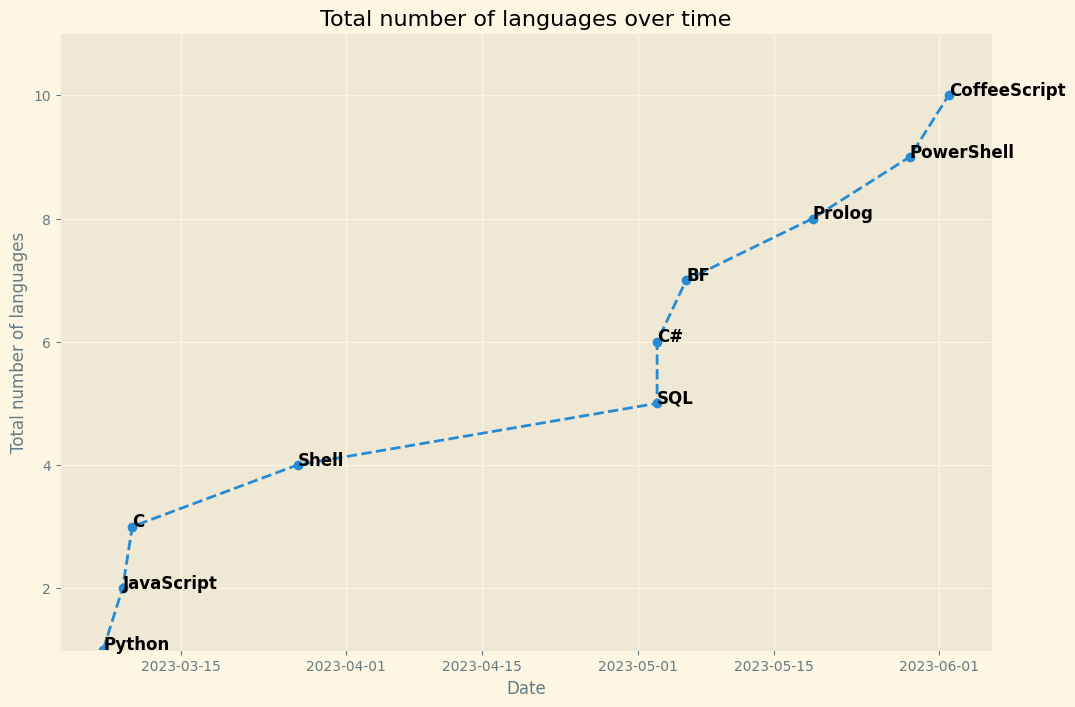

In [44]:
# Plot total languages over time
plt.figure(figsize=(12, 8))
plt.plot(first_appearance_df['first_appearance'], first_appearance_df['total_languages'], marker='o', linestyle='--')
plt.ylabel('Total number of languages')
plt.xlabel('Date')
plt.title('Total number of languages over time')
plt.ylim(1, first_appearance_df['total_languages'].iloc[-1] + 1)

# Add labels to the points
for i, language in enumerate(first_appearance_df['language']):
    plt.annotate(language, (first_appearance_df['first_appearance'].iloc[i], first_appearance_df['total_languages'].iloc[i]), weight='bold', fontsize=12)

#### <a id='toc1_7_1_2_'></a>[Representation of Languages Over Time](#toc0_)

In [47]:
language_representation_df = codewars_df[['problem_id', 'language', 'date_time']].copy()
language_representation_df['date_time'] = language_representation_df['date_time'].dt.date
language_representation_df.sort_values('date_time', inplace=True)
language_representation_df.head()

,problem_id,language,date_time
163,5641275f07335295f10000d0,Python,2023-03-07
134,5412509bd436bd33920011bc,Python,2023-03-07
32,5641275f07335295f10000d0,Python,2023-03-07
93,50654ddff44f800200000004,Python,2023-03-07
139,53af2b8861023f1d88000832,Python,2023-03-07


In [48]:
# Now we need to count the number of problems per language per day
language_representation_df = language_representation_df.groupby(['language', 'date_time']).agg({'problem_id': 'count'}).reset_index()
# Now we can apply a cumsum
language_representation_df['total_problems'] = language_representation_df.groupby('language')['problem_id'].cumsum()
language_representation_df.describe()

,problem_id,total_problems
count,102.000000,102.000000
mean,5.872549,77.960784
std,6.867446,89.609596
min,1.000000,1.000000
25%,2.000000,14.250000
50%,4.000000,38.000000
75%,7.000000,102.750000
max,44.000000,300.000000


In [49]:
language_representation_df.head()

,language,date_time,problem_id,total_problems
0,BF,2023-05-06,2,2
1,BF,2023-05-07,1,3
2,BF,2023-05-09,2,5
3,BF,2023-05-15,6,11
4,BF,2023-05-17,2,13


In [50]:
from datetime import timedelta

# Add values to the chart where there will be holes (from problem count not starting at 0, from problems not being completed on the last day of the dataset)
max_date = language_representation_df['date_time'].max()
for language in language_representation_df['language'].unique():
    # Entry with the max date of the entire dataframe and the max total_problems for each language
    max_total_problems = language_representation_df[language_representation_df['language'] == language]['total_problems'].max()
    max_date_row = [language, max_date, "", max_total_problems]
    language_representation_df.loc[len(language_representation_df)] = max_date_row
    
    # An entry for each language at the day before the first appearance with 0 total_problems
    first_appearance = first_appearance_df[first_appearance_df['language'] == language]['first_appearance'].values[0]
    min_date_row = [language, first_appearance - timedelta(days=1), "", 0]
    language_representation_df.loc[len(language_representation_df)] = min_date_row

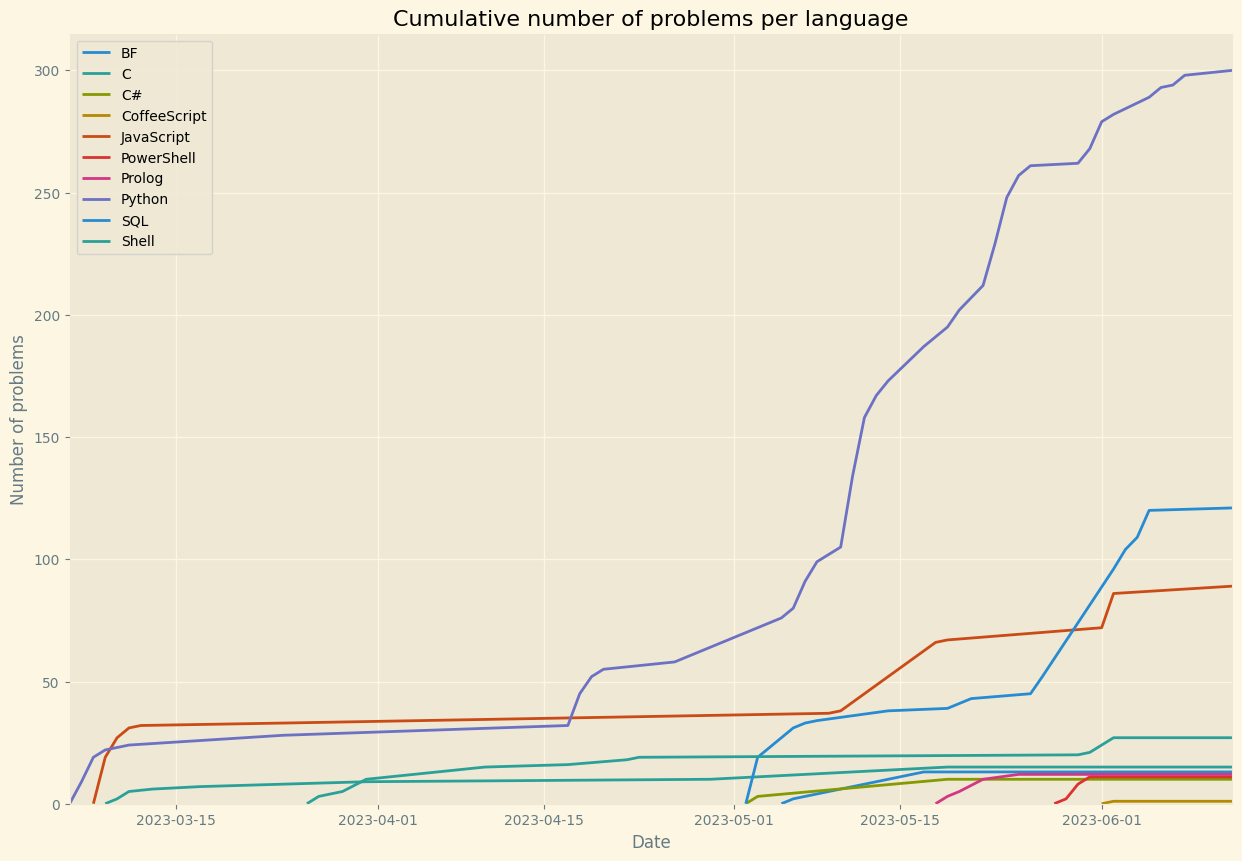

In [51]:
# Plot line chart
fig, ax = plt.subplots(figsize=(15, 10))
for key, grp in language_representation_df.groupby(['language']):
    ax = grp.plot(ax=ax, kind='line', x='date_time', y='total_problems', label=key)
plt.legend(loc='best')
plt.title('Cumulative number of problems per language')
plt.xlabel('Date')
plt.ylabel('Number of problems')
min_date = language_representation_df['date_time'].min()
plt.xlim(min_date, max_date)
plt.ylim(0, language_representation_df['total_problems'].max() * 1.05)
plt.show()

### <a id='toc1_7_2_'></a>[Analysis of Tags](#toc0_)

In [52]:
import ast
# Create a series by extracting the tags column as a list
tags_series = pd.Series(codewars_df['tags'].apply(ast.literal_eval))

#### <a id='toc1_7_2_1_'></a>[Tag Frequency](#toc0_)

In [53]:
# Let's get a list of tags
tag_counts = {}
for tag_list in tags_series:
    for tag in tag_list:
        if tag not in tag_counts:
            tag_counts[tag] = 1
        else:
            tag_counts[tag] += 1
            
# Get tag_counts sorted by value
sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)

[('Fundamentals', 475),
 ('Strings', 133),
 ('Algorithms', 127),
 ('Arrays', 103),
 ('Mathematics', 89),
 ('SQL', 65),
 ('Regular Expressions', 39),
 ('Databases', 29),
 ('Puzzles', 21),
 ('Lists', 21),
 ('Debugging', 13),
 ('Performance', 10),
 ('Data Science', 10),
 ('Geometry', 9),
 ('Logic', 7),
 ('Games', 5),
 ('Data Structures', 5),
 ('Sorting', 5),
 ('ASCII Art', 5),
 ('Refactoring', 5),
 ('Date Time', 4),
 ('Number Theory', 4),
 ('Tutorials', 4),
 ('Linear Algebra', 3),
 ('NumPy', 3),
 ('Parsing', 3),
 ('Cryptography', 3),
 ('Restricted', 3),
 ('Recursion', 3),
 ('Matrix', 3),
 ('Filtering', 2),
 ('Graph Theory', 2),
 ('Object-oriented Programming', 2),
 ('Dynamic Programming', 2),
 ('Binary', 2),
 ('Ciphers', 2),
 ('Algebra', 2),
 ('Functional Programming', 2),
 ('Bits', 2),
 ('Linked Lists', 2),
 ('Combinatorics', 1),
 ('Design Patterns', 1),
 ('Permutations', 1),
 ('Statistics', 1),
 ('Game Solvers', 1),
 ('Memoization', 1),
 ('Interpreters', 1),
 ('Security', 1)]

In [54]:
# Clean up the tags:
# Remove tags with 2 or less occurances
# Remove "Fundamentals" because it's massively over-represented
# Remove SQL because the SQL tag is only used for SQL specific problems
tag_counts = {k: v for k, v in tag_counts.items() if v > 2 and k != 'Fundamentals' and k != 'SQL'}

#### <a id='toc1_7_2_2_'></a>[Lollipop chart](#toc0_)

Text(0.5, 1.0, 'Number of problems per tag')

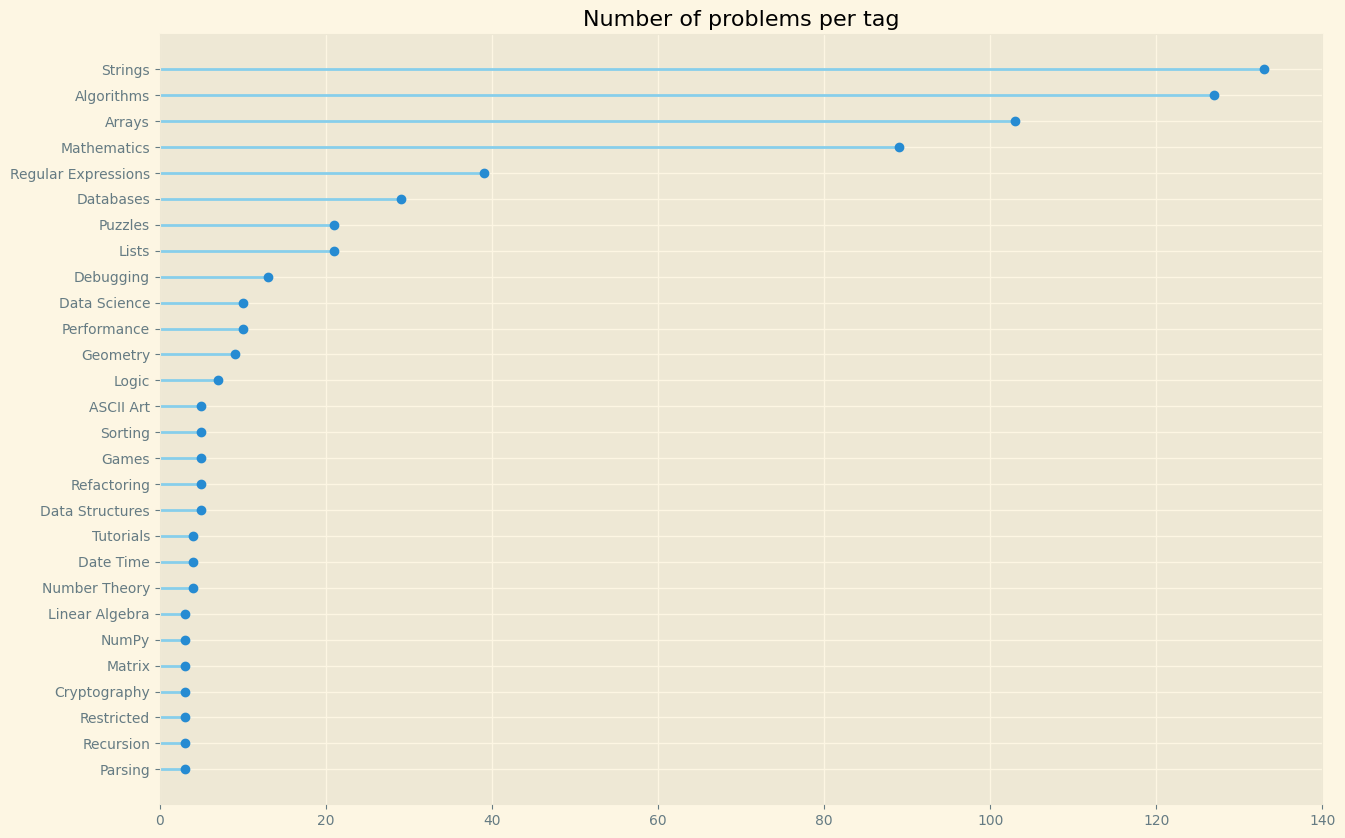

In [55]:
# Create a dataframe
# Reorder it following the values:
tags_df = pd.DataFrame.from_dict(tag_counts, orient='index', columns=['count']).sort_values(by='count')
my_range=range(1,len(tags_df.index)+1)
fig = plt.subplots(figsize=(15, 10))
plt.hlines(y=my_range, xmin=0, xmax=tags_df['count'], color='skyblue')
plt.plot(tags_df['count'], my_range, "o")

# Round the max value to the nearest 10
plt.xlim(0, round(tags_df['count'].max()/10 + 1) * 10)
plt.yticks(my_range, tags_df.index);

plt.title('Number of problems per tag')

# Make the plot
# plt.stem(ordered_df['values'])
# plt.xticks( my_range, ordered_df['group'])

del tags_df

#### <a id='toc1_7_2_3_'></a>[Top Tag Representation Over Time](#toc0_)

In [56]:
# Top n tags
num_tags = 6
top_tags = [tag for tag in sorted(tag_counts.items(), key=lambda x: x[1], reverse=True)[:num_tags]]
# Get the tag names
top_tags = [tag[0] for tag in top_tags]

# Now we can analysis the tag representation over time in a new dataframe
tag_representation_df = codewars_df[['date_time', 'tags']].copy()

# Convert date time to just date
tag_representation_df['date_time'] = tag_representation_df['date_time'].dt.date
tag_representation_df['date_time'] = pd.to_datetime(tag_representation_df['date_time'])
tag_representation_df.rename(columns={'date_time': 'date'}, inplace=True)

# Convert tags to a list then create columns for each tag
tag_representation_df['tags'] = tag_representation_df['tags'].apply(ast.literal_eval)
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df['tags'].apply(lambda x: int(tag in x))

# Drop the original tags column
tag_representation_df.drop('tags', axis=1, inplace=True)

tag_representation_df.shape

(599, 7)

In [57]:
tag_representation_df.head()

,date,Strings,Algorithms,Arrays,Mathematics,Regular Expressions,Databases
0,2023-04-08,0,0,0,0,0,0
1,2023-03-27,1,0,0,0,0,0
2,2023-04-08,0,0,0,0,0,0
3,2023-04-17,0,1,0,1,0,0
4,2023-03-31,0,0,0,0,0,0


In [58]:
# Group by date
tag_representation_df = tag_representation_df.groupby('date').sum()

In [59]:
tag_representation_df.shape

(60, 6)

In [60]:
tag_representation_df.head()

,Strings,Algorithms,Arrays,Mathematics,Regular Expressions,Databases
date,,,,,,
2023-03-07,3,2,2,0,0,0
2023-03-08,2,7,2,2,0,0
2023-03-09,4,3,10,2,0,0
2023-03-10,4,0,2,1,0,0
2023-03-11,3,2,0,0,0,0


In [61]:
# Final step is to change the tag columns to sums
for tag in top_tags:
    tag_representation_df[tag] = tag_representation_df[tag].cumsum()
    
tag_representation_df.head()

,Strings,Algorithms,Arrays,Mathematics,Regular Expressions,Databases
date,,,,,,
2023-03-07,3,2,2,0,0,0
2023-03-08,5,9,4,2,0,0
2023-03-09,9,12,14,4,0,0
2023-03-10,13,12,16,5,0,0
2023-03-11,16,14,16,5,0,0


(19423.0, 19520.0)

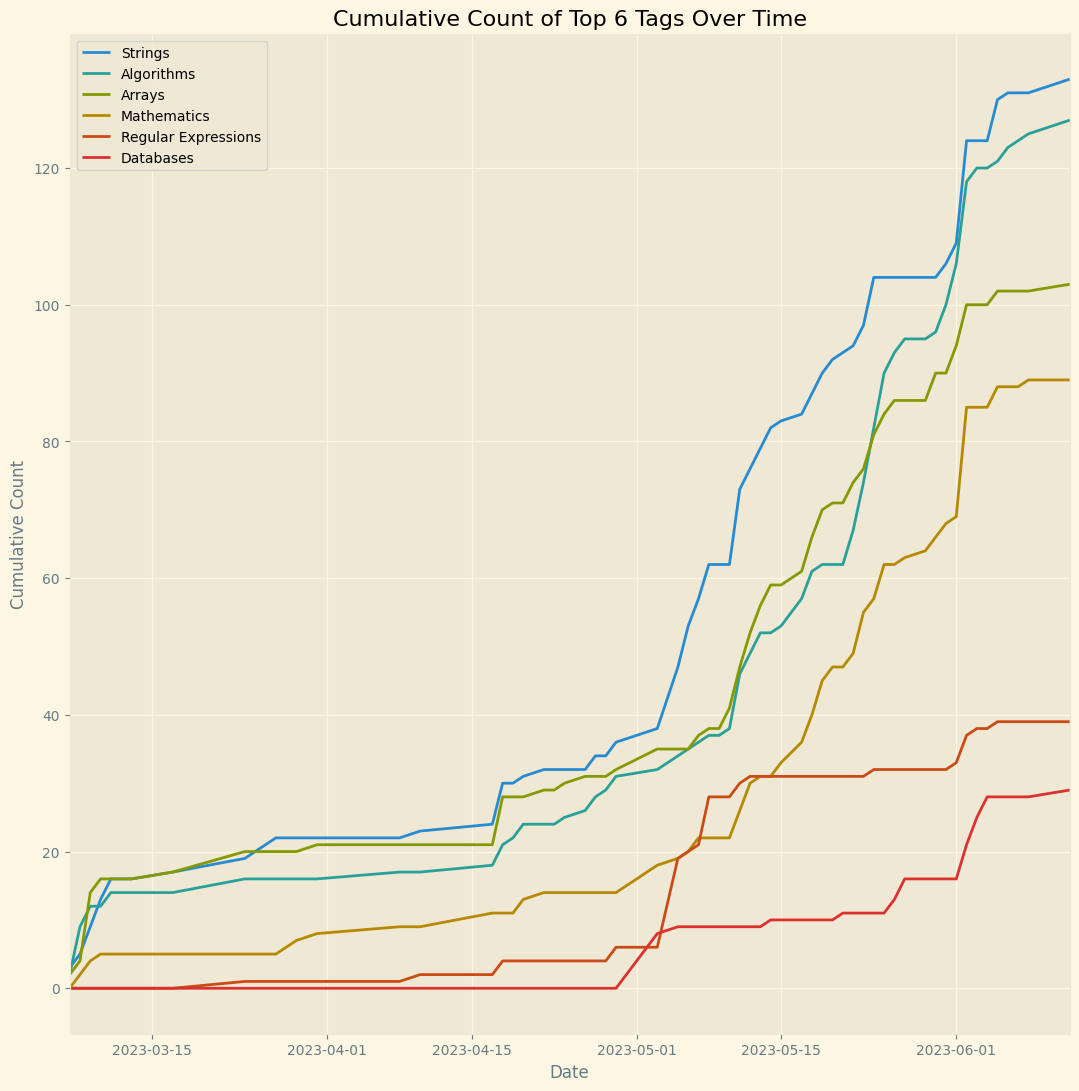

In [63]:
# Side note: I can't believe I actually got that to work
# Now we can plot the data
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_axes([0, 0, 1, 1])
ax1.set(xlabel='Date', ylabel='Cumulative Count', title=f'Cumulative Count of Top {num_tags} Tags Over Time')
ax1.plot(tag_representation_df)
ax1.legend(top_tags)
# Set limits
ax1.set_xlim([pd.Timestamp(tag_representation_df.index[0]), pd.Timestamp(tag_representation_df.index[-1])])

In [ ]:
del tag_representation_df

#### <a id='toc1_7_2_4_'></a>[Tags vs Language Heatmap](#toc0_)

In [64]:
# We'll make a new dataframe with language counts and tag list
language_tags_df = codewars_df[['language', 'tags']].copy()
language_tags_df['tags'] = language_tags_df['tags'].apply(ast.literal_eval)

In [65]:
# Create a dictionary with a list of dictionaries for each language
language_tags_dict = {
    language: {} for language in language_tags_df['language'].unique()
}
language_tags_dict

{'Shell': {},
 'Python': {},
 'BF': {},
 'SQL': {},
 'JavaScript': {},
 'C': {},
 'C#': {},
 'Prolog': {},
 'PowerShell': {},
 'CoffeeScript': {}}

In [66]:
# Now we can use iterrows to start filling in the dictionary
# We'll also blacklist some tags that are too common or not useful
blacklisted_tags = ['Fundamentals', 'SQL']

for index, row in language_tags_df.iterrows():
    language = row['language']
    tags = row['tags']
    for tag in tags:
        if tag in blacklisted_tags:
            continue
        if tag not in language_tags_dict[language]:
            language_tags_dict[language][tag] = 1
        else:
            language_tags_dict[language][tag] += 1

In [67]:
# There's some clutter in the dictionary, so we'll filter out some less represented tags
lowest_tag_count = 3

for language in language_tags_dict:
    language_tags_dict[language] = {tag: count for tag, count in language_tags_dict[language].items() if count > lowest_tag_count}

# Then let's have a look at the counts
for language in language_tags_dict:
    print(language)
    print("Number of tags:", len(language_tags_dict[language]))

Shell
Number of tags: 3
Python
Number of tags: 14
BF
Number of tags: 2
SQL
Number of tags: 7
JavaScript
Number of tags: 6
C
Number of tags: 2
C#
Number of tags: 0
Prolog
Number of tags: 1
PowerShell
Number of tags: 1
CoffeeScript
Number of tags: 0


In [68]:
# Now we can create a dataframe from the dictionary
language_tags_df = pd.DataFrame.from_dict(language_tags_dict, orient='index')

In [69]:
language_tags_df.head()

,Strings,Algorithms,Mathematics,Games,Regular Expressions,Date Time,Lists,Arrays,Puzzles,Data Structures,Sorting,Debugging,Performance,Logic,Databases,Data Science
Shell,7.0,4.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Python,79.0,90.0,37.0,5.0,30.0,4.0,13.0,65.0,9.0,5.0,5.0,8.0,5.0,5.0,NaN,NaN
BF,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SQL,21.0,11.0,22.0,NaN,5.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,29.0,9.0
JavaScript,15.0,14.0,9.0,NaN,NaN,NaN,5.0,20.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Replace NaN with 0
language_tags_df.fillna(0, inplace=True)

<AxesSubplot:>

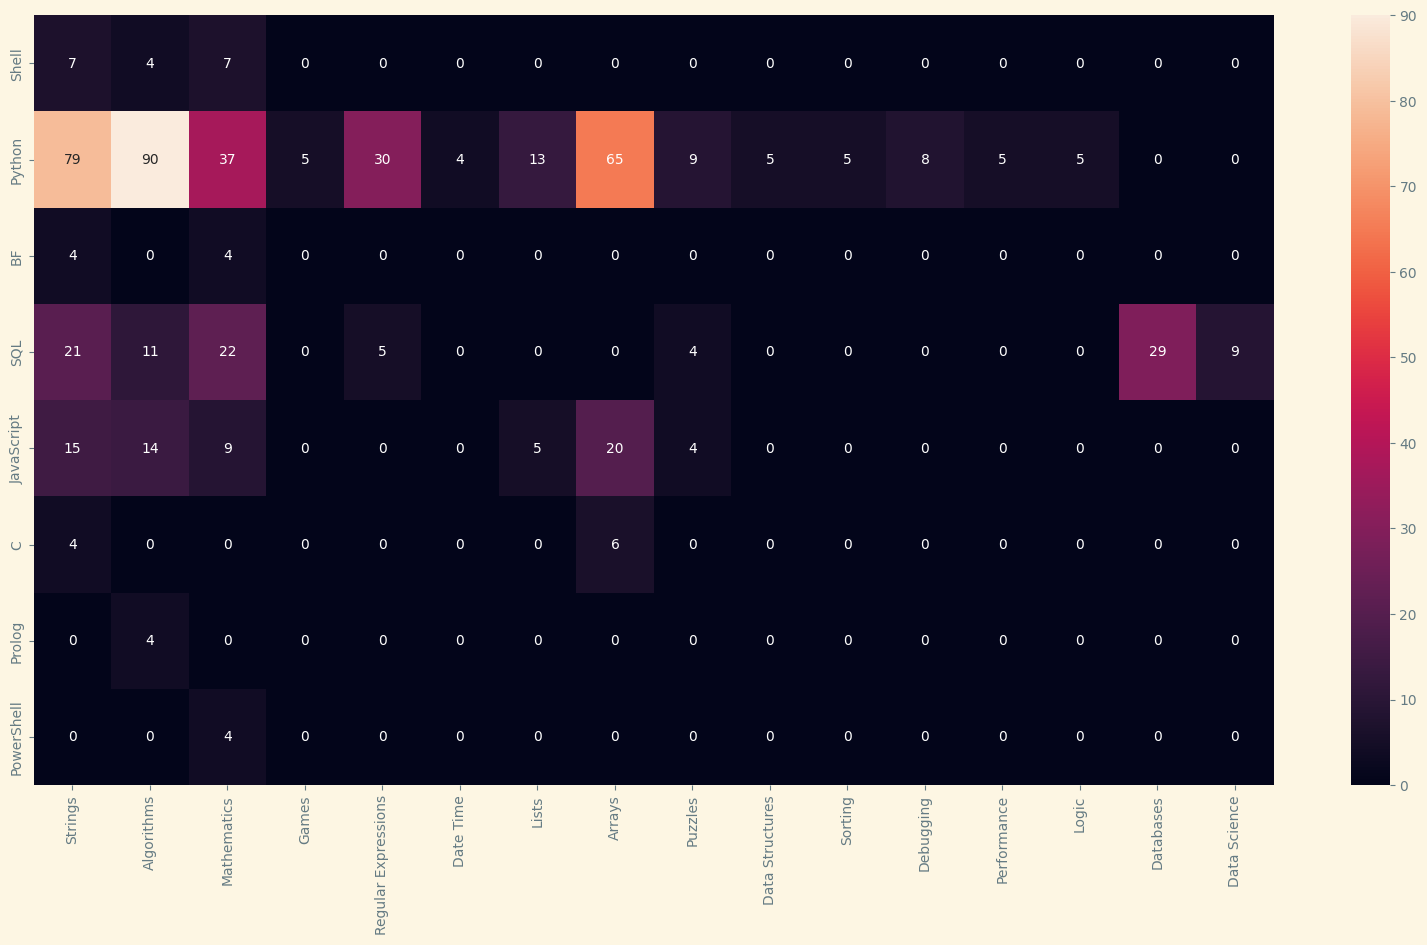

In [71]:
# Now let's create a heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(language_tags_df, annot=True, fmt='g', cmap='rocket')

In [ ]:
del language_tags_df

## <a id='toc1_8_'></a>[Difficulty Analysis](#toc0_)

### <a id='toc1_8_1_'></a>[Convert Difficulties into Numerical Values](#toc0_)

Text(0.5, 0, 'Difficulty')

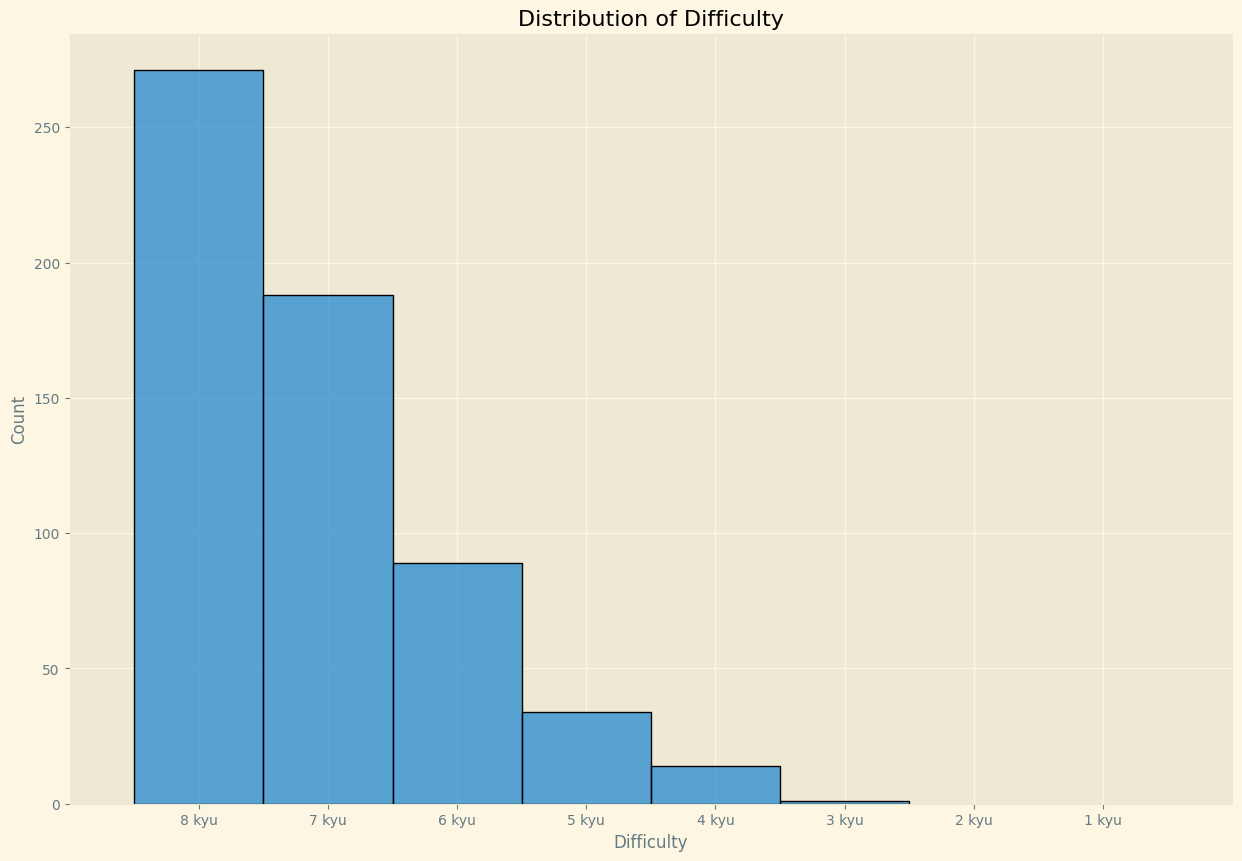

In [130]:
# Hist plot of difficulties
fig, axs = plt.subplots(figsize=(15, 10))
plt.title('Distribution of Difficulty')
sns.histplot(codewars_df['difficulty'].sort_values(ascending=False))
plt.xlim(-1, 8)
axs.set_xticks(range(8))
axs.set_xticklabels(['8 kyu', '7 kyu', '6 kyu', '5 kyu', '4 kyu', '3 kyu', '2 kyu', '1 kyu'])
axs.set_xlabel('Difficulty')

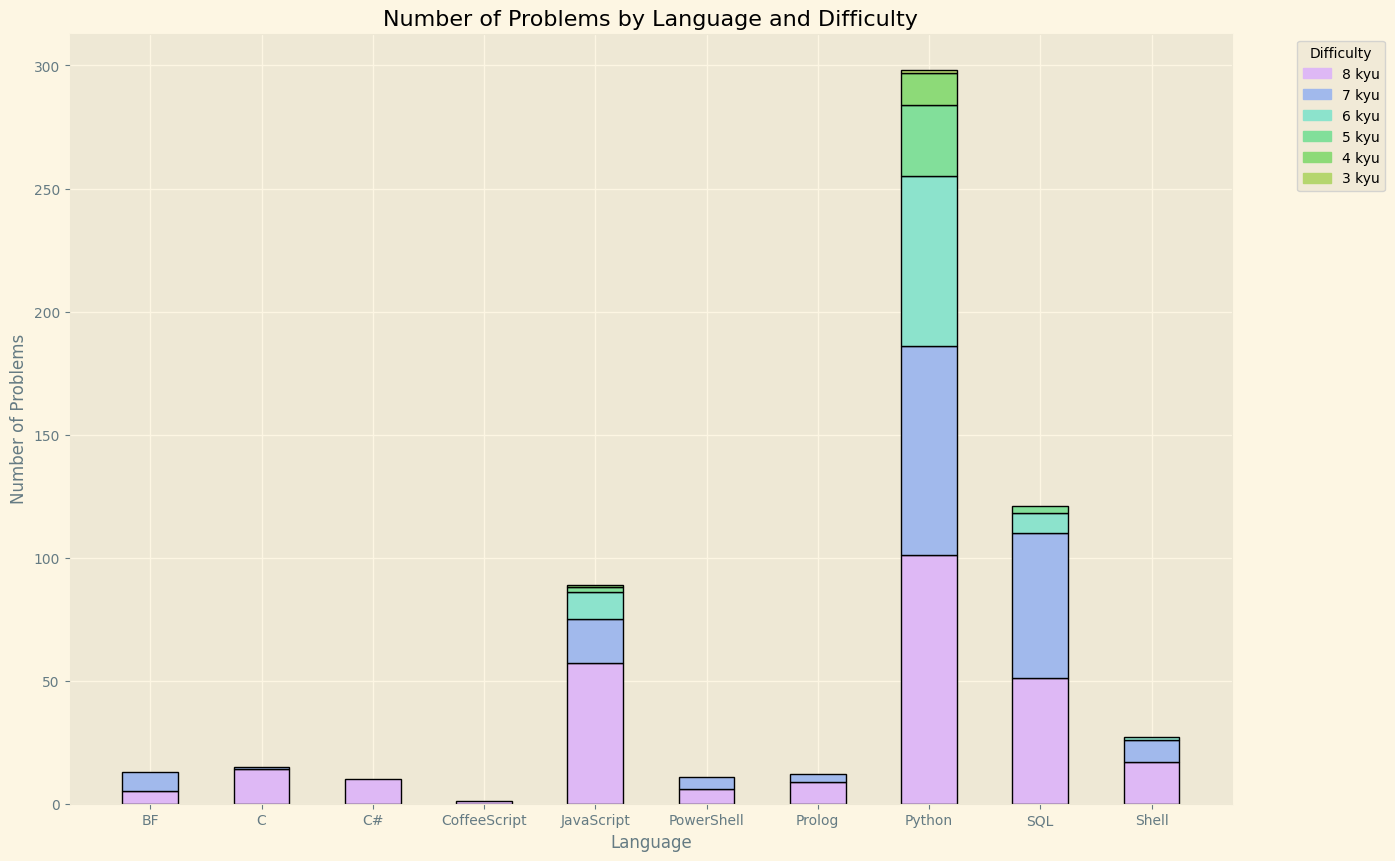

In [73]:
import matplotlib.patches as mpatches

difficulty_colors = {'8 kyu': '#DEB8F5', '7 kyu': '#a1b9ec', '6 kyu': '#8ce3cc', '5 kyu': '#82df9a', '4 kyu': '#8dda78', '3 kyu': '#b5d66e', '2 kyu': '#cd865b', '1 kyu': '#BA42C0'}

counts = codewars_df.groupby(['language', 'difficulty']).size().reset_index(name='counts').sort_values(by=['language', 'difficulty'], ascending=[True, False])

width = 0.5

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
bottom = np.zeros(len(counts['language'].unique()))

counts['language'].unique()


for i, row in counts.iterrows():
    language = row['language']
    difficulty = row['difficulty']
    count = row['counts']
    bottom_index = counts['language'].unique().tolist().index(language)
    
    p = ax.bar(language, count, width, label=difficulty, bottom=bottom[bottom_index], color=difficulty_colors[difficulty], lw=1, edgecolor='black')
    bottom[bottom_index] += count

unique_difficulties = counts['difficulty'].unique()
legend_patches = [mpatches.Patch(color=difficulty_colors[difficulty], label=difficulty) for difficulty in unique_difficulties if difficulty in difficulty_colors]
ax.legend(handles = legend_patches, title='Difficulty', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Number of Problems by Language and Difficulty')
plt.ylabel('Number of Problems')
plt.xlabel('Language')
plt.show()

#### <a id='toc1_8_1_1_'></a>[Kata Completion Ratios](#toc0_)
Codewars tracks attempts at solving kata vs how may times it has been completed. From this we can calculate a completion ratio

In [74]:
# Add a new column called completion ratio
codewars_df['completion_ratio'] = codewars_df['completion_count'] / codewars_df['attempts']
codewars_df['completion_ratio'].head()

0    0.150284
1    0.459058
2    0.441892
3    0.523687
4    0.718761
Name: completion_ratio, dtype: float64

Text(0, 0.5, 'Difficulty')

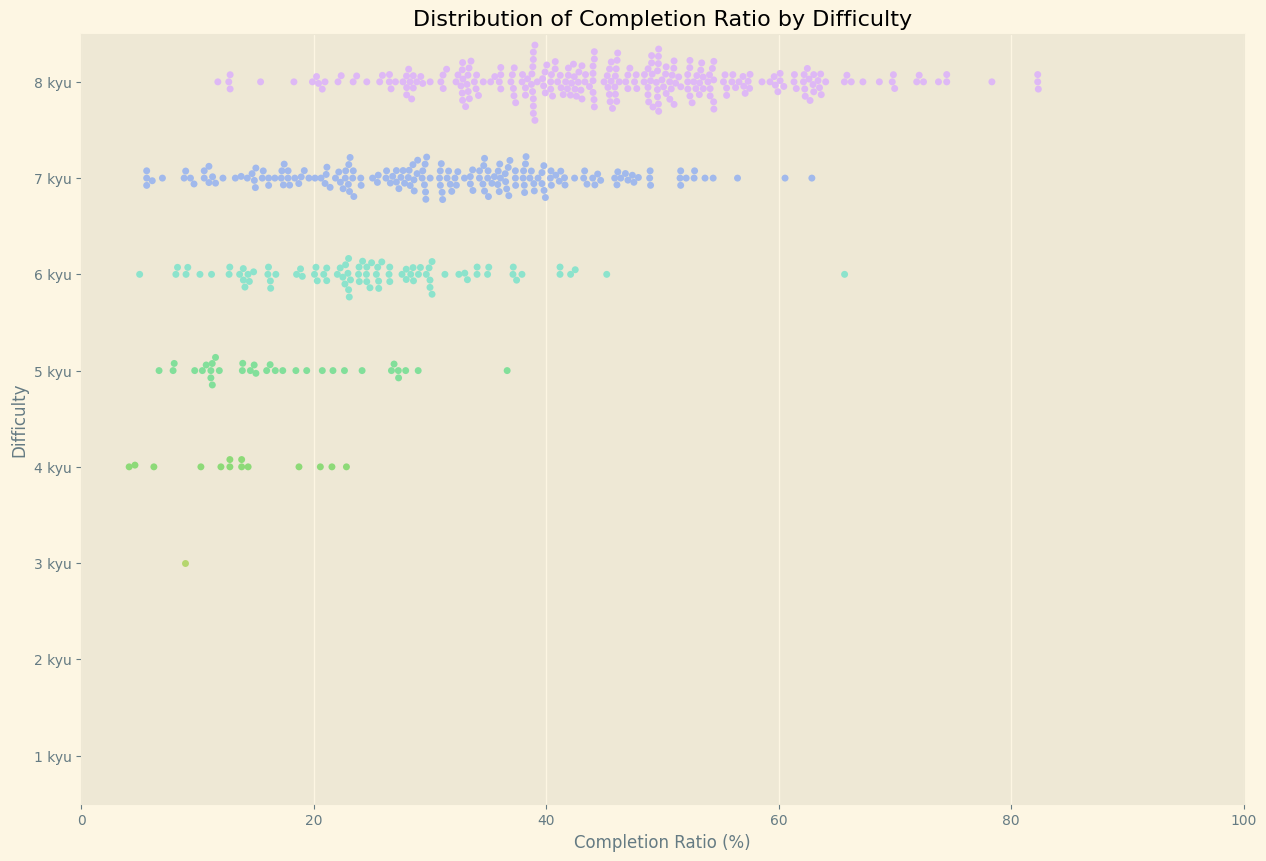

In [85]:
# Plot the distribution of completion ratios for each difficulty
# fig, axs = plt.subplots(figsize=(15, 10))
fig = plt.figure(figsize=(15, 10))
difficulties = ['8 kyu', '7 kyu', '6 kyu', '5 kyu', '4 kyu', '3 kyu', '2 kyu', '1 kyu']
# Use a swarm plot
sns.swarmplot(data=codewars_df, x=codewars_df['completion_ratio'] * 100, y='difficulty', palette=difficulty_colors, order=difficulties)
plt.title('Distribution of Completion Ratio by Difficulty')
plt.xlabel('Completion Ratio (%)')
plt.xlim(0, 100)
plt.ylabel('Difficulty')

#### <a id='toc1_8_1_2_'></a>[Most Difficult Kata Solved](#toc0_)
The most difficult kata will be defined as the kata with the lowest proportion of completions to attempts

In [120]:
# Find the index of the lowest completion ratio
lowest_completion_ratio_index = codewars_df['completion_ratio'].idxmin()

# Now we can take a look with iloc
lowest_completion_details = codewars_df.iloc[lowest_completion_ratio_index]
lowest_completion_details

problem_id                                      537e18b6147aa838f600001b
language                                                          Python
revision                                                               1
solution               import math\n\n\n\n\n\ndef justify(text, width...
link                   https://www.codewars.com/kata/537e18b6147aa838...
date_time                                     2023-03-11 13:55:50.542000
title                                                 Text align justify
difficulty                                                         4 kyu
difficulty_category                                                 blue
attempts                                                          148534
completion_count                                                    6134
author                                                        kesheshyan
tags                                           ['Strings', 'Algorithms']
published_at                            2014-05-22 

In [124]:
def get_kata_solution_markdown(details):
    import pyperclip
    # Generate the markdown text for the cell below
    title = details['title']
    completion_ratio = details['completion_ratio']
    completion_count = details['completion_count']
    attempts = details['attempts']
    difficulty = details['difficulty']
    language = details['language']
    solution = details['solution'].replace("\n\n", "\n")
    issues = details['issues']

    # Text interpolation works weirdly when spanning multiple lines
    markdown_text = f"""# {title}  
**Completion ratio:** {completion_ratio}  
**Completion count:** {completion_count}  
**Attempts:** {attempts}  
**Difficulty:** {difficulty}  
**Language:** {language}  
**Issues**: {issues}  
**Solution:**  
```
{solution}
```"""

    # Copy the markdown text to the clipboard
    pyperclip.copy(markdown_text)
    print("Paste the markdown text below into a new cell in your notebook")

In [125]:
get_kata_solution_markdown(lowest_completion_details)

Paste the markdown text below into a new cell in your notebook


# <a id='toc2_'></a>[Text align justify](#toc0_)
**Completion ratio:** 0.0412969421142634  
**Completion count:** 6134  
**Attempts:** 148534  
**Difficulty:** 4 kyu  
**Language:** Python  
**Issues**: 24  
**Solution:**  
```
import math


def justify(text, width):
    words = text.split()
    line = ""
    lines = []
    line_num = 0
    for word in words:
        word.rstrip()
        if len(line) + len(word) <= width:
            line += word + " "
        else:
            # strip whitespace from end of line and calculate how much remaining space there is
            line = line.rstrip()
            remaining_space = width - len(line)
            print("Line " + str(line_num) + ": " + line)
            print("Line length: " + str(len(line)))
            print("Remaining space" + str(remaining_space))
            if remaining_space == 0:
                lines.append(line + "\n")
                line = word + " "
                continue

            # split line into words
            line_words = line.split()
            # if there is only one word in the line, just continue because lines shouldn't end with a space
            if len(line_words) == 1:
                lines.append(line + "\n")
                line = word + " "
                continue
            # calculate how much extra space to add per word
            extra_spaces = math.floor(remaining_space / (len(line_words) - 1))
            # There may be an error because of flooring this number, so calculate how many gaps will have an extra space
            extra_space_gaps = remaining_space - \
                extra_spaces * (len(line_words) - 1)
            print(extra_space_gaps)
            # large gaps go first - clear line and start adding words and spaces
            line = ""
            for words in line_words[:-1]:
                line += words + " "
                if extra_space_gaps > 0:
                    line += " "
                    extra_space_gaps -= 1
                line += (" " * extra_spaces)
            # add last word to line
            line += line_words[-1] + "\n"

            # add line to lines list
            lines.append(line)
            # reset line
            line = word + " "

    # add last line to lines list
    lines.append(line.rstrip())
    return "".join(lines).rstrip()
```

#### <a id='toc2_1_1_1_'></a>[Rarest Kata](#toc0_)
This will be defined by the kata that has the lowest number of completions

In [126]:
# As we did with completion ratio
lowest_completion_count_index = codewars_df['completion_count'].idxmin()
lowest_completion_details = codewars_df.iloc[lowest_completion_count_index]
lowest_completion_details

problem_id                                      585fc200db20cf20ab00018a
language                                                          Python
revision                                                               1
solution               import numpy as np\n\n\n\ndef max_sum(arr):\n\...
link                   https://www.codewars.com/kata/585fc200db20cf20...
date_time                                     2023-05-23 13:45:04.010000
title                                            Maximum 2d subarray sum
difficulty                                                           NaN
difficulty_category                                                  NaN
attempts                                                             230
completion_count                                                      18
author                                                         MaLiN2223
tags                               ['Algorithms', 'Dynamic Programming']
published_at                            2016-12-25 

In [127]:
get_kata_solution_markdown(lowest_completion_details)

Paste the markdown text below into a new cell in your notebook


# <a id='toc3_'></a>[Maximum 2d subarray sum](#toc0_)
**Completion ratio:** 0.0782608695652174  
**Completion count:** 18  
**Attempts:** 230  
**Difficulty:** nan  
**Language:** Python  
**Issues**: 5  
**Solution:**  
```
import numpy as np

def max_sum(arr):
    arr = np.array(arr)
    max_sum = -1
    max_subarray = []
    rows, cols = arr.shape
    
    for start_row in range(rows):
        row_sums = np.zeros(cols)
        
        for end_row in range(start_row, rows):
            row_sums += arr[end_row]
            
            # Apply Kadane's algorithm to find the maximum sum subarray in the 1D array
            current_sum = 0
            max_sum_so_far = 0
            start_col = 0
            end_col = 0
            
            for j, num in enumerate(row_sums):
                current_sum += num
                
                if current_sum < 0:
                    current_sum = 0
                    start_col = j + 1
                elif current_sum > max_sum_so_far:
                    max_sum_so_far = current_sum
                    end_col = j
            
            # Check if the current subarray has the maximum sum
            if max_sum_so_far > max_sum:
                max_sum = max_sum_so_far
                max_subarray = [start_col, start_row, end_col, end_row]
    
    return max_subarray + [max_sum]

```

#### <a id='toc3_1_1_1_'></a>[Most Problematic Kata](#toc0_)

The kata with the most issues reported

In [128]:
codewars_df['issues'].idxmax()
most_problematic_details = codewars_df.iloc[codewars_df['issues'].idxmax()]
most_problematic_details

problem_id                                      51fda2d95d6efda45e00004e
language                                                          Python
revision                                                               1
solution               # TODO: create the User class\n\n# it must sup...
link                   https://www.codewars.com/kata/51fda2d95d6efda4...
date_time                                     2023-05-22 20:53:51.940000
title                                      Codewars style ranking system
difficulty                                                         4 kyu
difficulty_category                                                 blue
attempts                                                          294994
completion_count                                                   13655
author                                                          jhoffner
tags                                                      ['Algorithms']
published_at                            2013-08-22 

In [129]:
get_kata_solution_markdown(most_problematic_details)

Paste the markdown text below into a new cell in your notebook


# <a id='toc4_'></a>[Codewars style ranking system](#toc0_)
**Completion ratio:** 0.046289077065974224  
**Completion count:** 13655  
**Attempts:** 294994  
**Difficulty:** 4 kyu  
**Language:** Python  
**Issues**: 31  
**Solution:**  
```
# TODO: create the User class
# it must support rank, progress, and the inc_progress(rank) method
ranks = [-8, -7, -6, -5, -4, -3, -2, -1, 1, 2, 3, 4, 5, 6, 7, 8]
class User:
    def __init__(self):
        self.rank = -8
        self.progress = 0
        
    def inc_progress(self, rank):
        rank_pos = ranks.index(self.rank)
        challenge_rank_pos = ranks.index(rank)
        diff = challenge_rank_pos - rank_pos
        progress = 0
        if diff == -1:
            progress = 1
        elif diff == 0:
            progress = 3
        elif diff > 0:
            progress = 10 * diff * diff
            
        self.progress += progress
        
        while self.progress >= 100:
            try:
                self.rank = ranks[ranks.index(self.rank) + 1]
                self.progress -= 100
            except:
                self.rank = ranks[len(ranks) - 1]
                self.progress = 0
                break
                
        if self.rank == 8:
            self.progress = 0
```

#### <a id='toc4_1_1_1_'></a>[Favourite Authors](#toc0_)

In [104]:
# Make a dictionary of the top 10 authors
author_dict = {}
for key, value in codewars_df.value_counts('author').sort_values(ascending=False).head(10).items():
    author_dict[key] = value

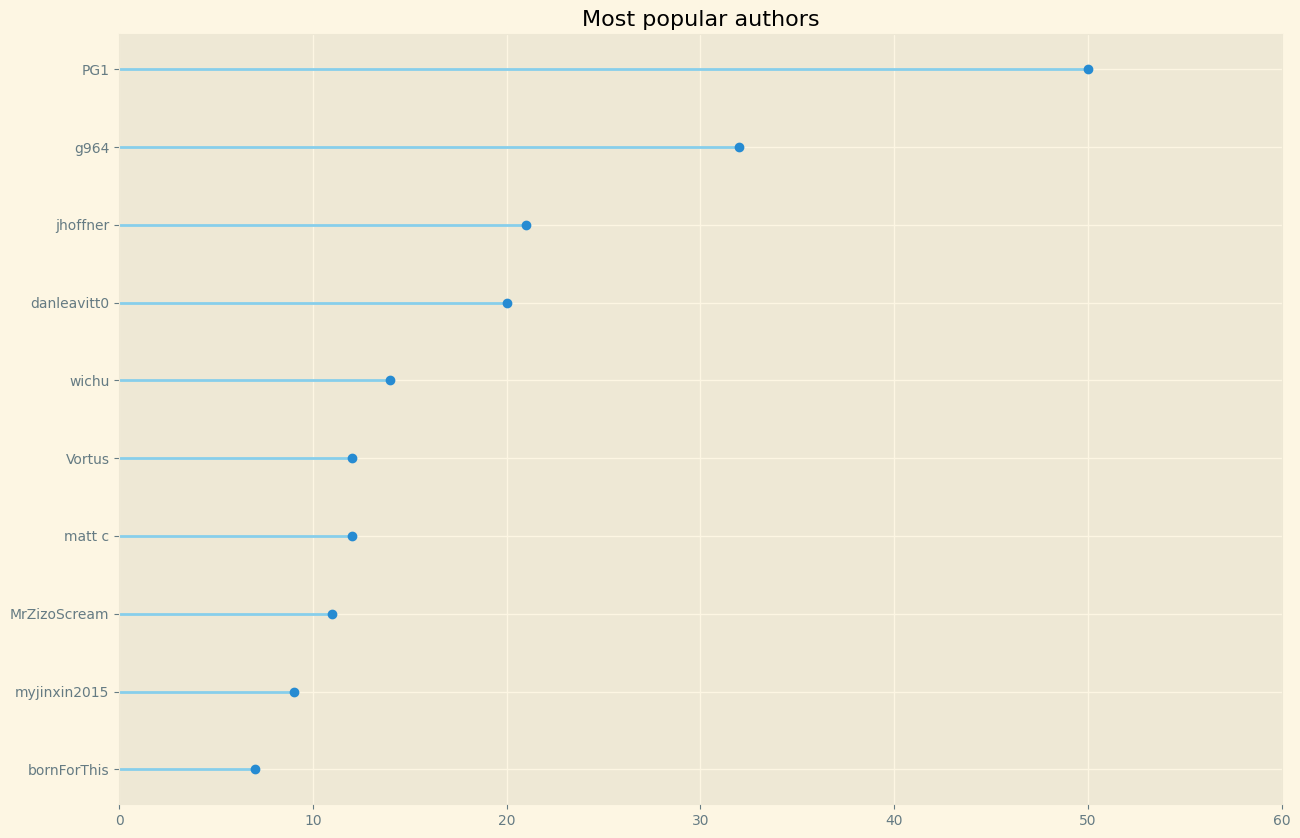

In [111]:
# Plot on a lollipop chart
authors_df = pd.DataFrame.from_dict(author_dict, orient='index', columns=['count']).sort_values(by='count', ascending=True)
my_range=range(1,len(authors_df.index)+1)
fig = plt.subplots(figsize=(15, 10))
plt.hlines(y=my_range, xmin=0, xmax=authors_df['count'], color='skyblue')
plt.plot(authors_df['count'], my_range, "o")

# Round the max value to the nearest 10
plt.xlim(0, round(authors_df['count'].max()/10 + 1) * 10)
plt.yticks(my_range, authors_df.index);

plt.title('Most popular authors')

del authors_df, author_dict